# **ASSIGNMENT 3**

**Task**: forecast the real price of gasoline for the US.

**Dataset**: gasoline.xlsx contains two monthly time series. The nominal price of gasoline and the CPI. 


In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from fredapi import Fred
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf

pd.set_option("display.precision", 2)

In [98]:
gasoline = pd.read_excel('gasoline.xls')

# rename the columns
gasoline.rename(columns=
                {'Unnamed: 1': 'CPI',
                 'Unnamed: 2': 'Nominal_Price',
                 'FRED Graph Observations': 'Time'},
                 inplace = True)

# convert to datetime
gasoline['Time'] = pd.to_datetime(gasoline['Time'], errors = 'coerce')

# remove the unnecessary descriptions
gasoline = gasoline.query("Time >= '1990-11-01'")

gasoline.head()

,Time,CPI,Nominal_Price
11,1990-11-01,1.32,133.7
12,1990-12-01,1.34,134.2
13,1991-01-01,1.18,134.7
14,1991-02-01,1.09,134.8
15,1991-03-01,1.04,134.8


# 1) create the real price of gasoline

CPI has value = 100 for 1984: is it meaningful, considering that the observations begin from 1990?

In [99]:
gasoline['Real_Price'] = (gasoline['Nominal_Price']/gasoline['CPI'])*100
gasoline.head(5)

,Time,CPI,Nominal_Price,Real_Price
11,1990-11-01,1.32,133.7,10098.19
12,1990-12-01,1.34,134.2,10007.46
13,1991-01-01,1.18,134.7,11415.25
14,1991-02-01,1.09,134.8,12318.94
15,1991-03-01,1.04,134.8,12961.54


It should be: nominal/cpi_base_year*cpi_present_year

## 2)  Plot real and nominal prices over time.

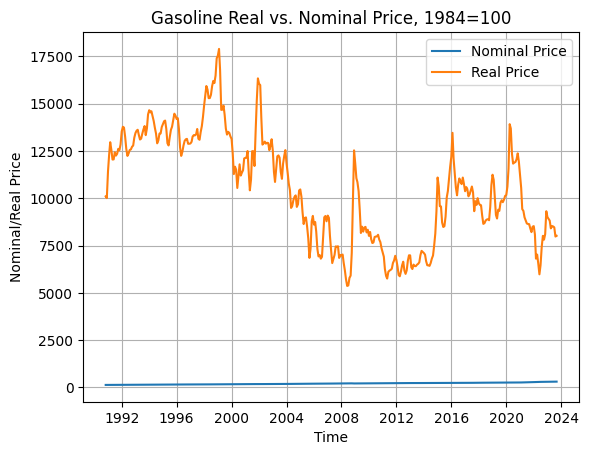

In [100]:
plt.plot(gasoline['Time'], gasoline['Nominal_Price'], label = 'Nominal Price')
plt.plot(gasoline['Time'], gasoline['Real_Price'], label='Real Price')

plt.title('Gasoline Real vs. Nominal Price, 1984=100')
plt.xlabel('Time')
plt.ylabel('Nominal/Real Price')
plt.legend()
plt.grid()

Alternatively, plot them separately. Be aware of the different y-axis!

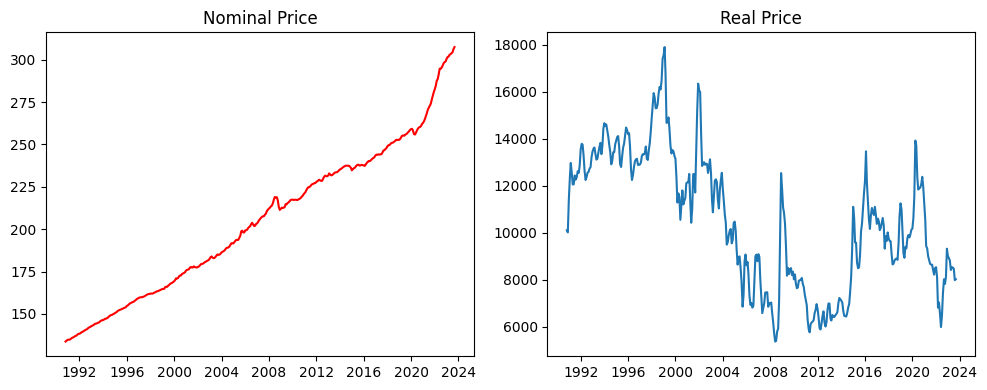

In [101]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(10,4))
ax[0].plot(gasoline['Time'], gasoline['Nominal_Price'], color='red')
ax[0].set_title('Nominal Price')

ax[1].plot(gasoline['Time'], gasoline['Real_Price'])
ax[1].set_title('Real Price')

plt.tight_layout()
plt.show()

## 3) Consider the sample from obs 1 to Dec 2014. Plot the sample ACF of $y_{t}$ and $\Delta{y_t} = y_{t} - y_{t-1}$


In [102]:
# filter the data as requestes
filtered_gasoline = gasoline.query(" Time <= '2014-12-01'")

# convert the data from float to numeric...
filtered_gasoline['Real_Price'] = pd.to_numeric(filtered_gasoline['Real_Price'], errors='coerce')

# ... otherwise we couldn't apply the .log() function
filtered_gasoline['Log_Real_Price'] = np.log(filtered_gasoline['Real_Price'])

# create the column delta for the first difference of the log price
filtered_gasoline['Delta_Log'] = (filtered_gasoline['Log_Real_Price']-filtered_gasoline['Log_Real_Price'].shift(1))

# fill the first value with 0, otherwise the next code chunk won't produce an accurate ACF
filtered_gasoline['Delta_Log'].fillna(0, inplace=True)

filtered_gasoline.tail()

C:\Users\giord\AppData\Local\Temp\ipykernel_22064\4129526131.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_gasoline['Real_Price'] = pd.to_numeric(filtered_gasoline['Real_Price'], errors='coerce')
C:\Users\giord\AppData\Local\Temp\ipykernel_22064\4129526131.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_gasoline['Log_Real_Price'] = np.log(filtered_gasoline['Real_Price'])
C:\Users\giord\AppData\Local\Temp\ipykernel_22064\4129526131.py:11: SettingWithCopyWarning: 
A value is trying

,Time,CPI,Nominal_Price,Real_Price,Log_Real_Price,Delta_Log
296,2014-08-01,3.49,237.46,6810.84,8.83,0.03
297,2014-09-01,3.41,237.48,6971.90,8.85,0.02
298,2014-10-01,3.17,237.43,7488.72,8.92,0.07
299,2014-11-01,2.91,236.98,8137.45,9.00,0.08
300,2014-12-01,2.54,236.25,9291.75,9.14,0.13


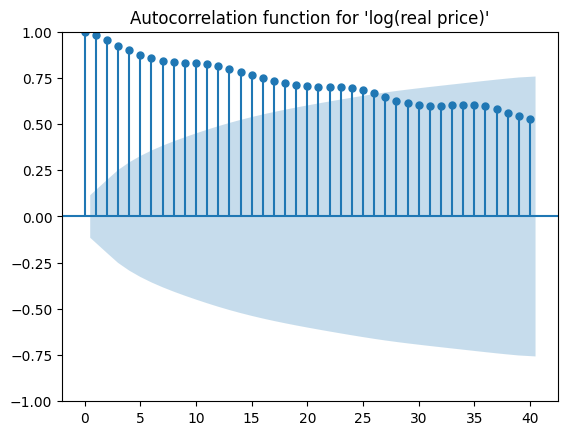

In [110]:
plot_acf(filtered_gasoline['Log_Real_Price'], 
         lags=40,
         title="Autocorrelation function for 'log(real price)'");

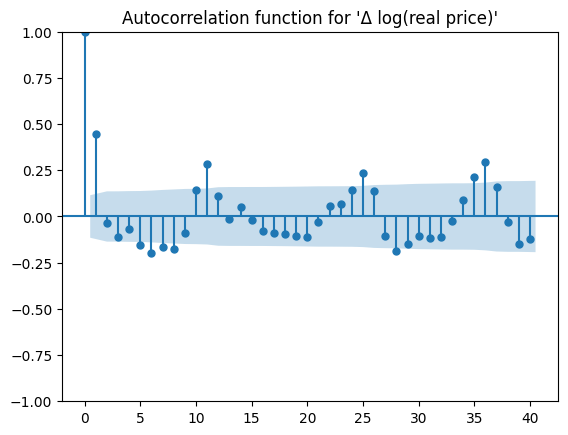

In [111]:
plot_acf(filtered_gasoline['Delta_Log'], 
         lags=40, 
         title="Autocorrelation function for 'Δ log(real price)'");

## 4) Using the same sample above fit two AR(1) models: the first for **$y_{t}$** and the second for **Δ$y_{t}$**. Report in both cases the coefficient associated with the lagged dependent variable.


In [115]:
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import adfuller
# If the pvalue is above a critical size, then we cannot reject that there is a unit root.

stationarity_test = adfuller(filtered_gasoline['Log_Real_Price'], autolag='AIC')
stationarity_test

(-1.1027056060143905,
 0.7139917355144692,
 15,
 274,
 {'1%': -3.4544435065994437,
  '5%': -2.8721468827772774,
  '10%': -2.572422013959188},
 -899.6724510402832)

Since the critical value, -1.10, is > than t-values at (1%,5%,10%), the null hypothesis CANNOT be rejected, where the null hypothesis is that there exists a unit root. If there exists a unit root, then the process is NON-stationary.


In my case, the ADF statistic is greater than the critical values. This suggests that the null hypothesis of a unit root is not rejected, indicating that the time series might indeed be NON-stationary (= it has relation with time).

Moreover, the p-value exceed the significance level of 0.01, 0.05, 0.1.

In [118]:
ar_log_real_price = AutoReg(filtered_gasoline['Log_Real_Price'], lags=1).fit()
print(ar_log_real_price.summary())

                            AutoReg Model Results                             
Dep. Variable:         Log_Real_Price   No. Observations:                  290
Model:                     AutoReg(1)   Log Likelihood                 427.345
Method:               Conditional MLE   S.D. of innovations              0.055
Date:                Wed, 18 Oct 2023   AIC                           -848.691
Time:                        12:41:38   BIC                           -837.692
Sample:                             1   HQIC                          -844.284
                                  290                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.1430      0.096      1.490      0.136      -0.045       0.331
Log_Real_Price.L1     0.9845      0.010     94.872      0.000       0.964       1.005
                        

c:\Users\giord\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [119]:
stationarity_test2 = adfuller(filtered_gasoline['Delta_Log'], autolag='AIC')
stationarity_test2

(-5.003640547528814,
 2.1827897361987434e-05,
 14,
 275,
 {'1%': -3.454355055831705,
  '5%': -2.8721080938842976,
  '10%': -2.572401325619835},
 -900.3701855523364)

In [120]:
ar_delta_log = AutoReg(filtered_gasoline['Delta_Log'], lags=1).fit()
print(ar_delta_log.summary())

                            AutoReg Model Results                             
Dep. Variable:              Delta_Log   No. Observations:                  290
Model:                     AutoReg(1)   Log Likelihood                 458.944
Method:               Conditional MLE   S.D. of innovations              0.049
Date:                Wed, 18 Oct 2023   AIC                           -911.888
Time:                        12:43:00   BIC                           -900.888
Sample:                             1   HQIC                          -907.480
                                  290                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         5.163e-05      0.003      0.018      0.986      -0.006       0.006
Delta_Log.L1     0.4547      0.053      8.568      0.000       0.351       0.559
                                    Roots   

c:\Users\giord\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


## 5) Produce a series of 1 step-ahead forecasts for yt. Use the following models: random walk (no drift), ARIMA(1,1,0), ARIMA(0,1,1), ARIMA(1,1,1). To produce forecasts start from the sample that ends in Dec 2014 and add 1 observation at the time (i.e. expanding/recursive scheme)